In [85]:
import xarray as xr
from cdo import *
import cdo
import numpy as np
import pandas as pd
from netCDF4 import Dataset
import cartopy.crs as ccrs
import subprocess
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import ScalarFormatter

In [182]:
tas_ocean = xr.open_dataset('tas_ocean.nc')
ts_ocean = xr.open_dataset('ts_ocean.nc')
ls_precip = xr.open_dataset('prl.nc')
convective_precip = xr.open_dataset('prc.nc')

In [3]:
cdo = Cdo()

In [139]:
#make 2D dataframes of each xarray
df_tas = tas_ocean[["tas"]].to_dataframe().reset_index()
df_ts = ts_ocean["ts"].to_dataframe().reset_index()
df_prl = ls_precip['prl'].to_dataframe().reset_index()
df_prc = convective_precip['prc'].to_dataframe().reset_index()
df_tas.head()

,time,lat,lon,bnds,tas,time_bnds
0,10116.0,85.760587,0.000,0,-231.757278,10101.0
1,10116.0,85.760587,0.000,1,-231.757278,10131.0
2,10116.0,85.760587,5.625,0,-231.721481,10101.0
3,10116.0,85.760587,5.625,1,-231.721481,10131.0
4,10116.0,85.760587,11.250,0,-231.765015,10101.0


In [172]:
#map time values to months
month_dict = {
    '01':'January',
    '02':'February',
    '03':'March',
    '04':'April',
    '05':'May',
    '06':'June',
    '07':'July',
    '08':'August',
    '09':'September',
    '10':'October',
    '11':'November',
    '12':'December'
}

def process_time(df,var):
    #pre-process datasets for time line graphs
    # Bin latitude into 20° bands
    df['lat_bin'] = (df['lat'] // 20) * 20  
    
    #abs value for tas
    df[var] = np.abs(df[var])
    
    # Group by time and latitude bins, then average variable
    df_time_var = (
        df.groupby(['time', 'lat_bin'])[var].mean().reset_index()
    )
    
    date_list = df_time_var['time'].tolist()
    month_list = []
    for date in date_list:
        second_two = str(date)[1:3]
        month_list.append(second_two)
    
    month_list = [month_dict[k] for k in month_list]
    df_time_var['month'] = month_list

    return df_time_var

In [173]:
df_time_tas = process_time(df_tas,'tas')
df_time_ts = process_time(df_ts,'ts')
df_time_prc = process_time(df_prc,'prc')
df_time_prl = process_time(df_prl,'prl')

In [174]:
df_time_tas.to_csv('time_tas.csv')
df_time_ts.to_csv('time_ts.csv')
df_time_prc.to_csv('time_prc.csv')
df_time_prl.to_csv('time_prl.csv')

In [117]:
#pre-processing to average by time and prep land/sea mask for tas and ts
def preprocess(df,var):
    #average time values
    df_avg = df.groupby(['lat','lon'])[var].mean().reset_index()
    #replace land mask with 220 values
    df_avg[var] = np.where(df_avg[var] == 0.0, 220, df_avg[var])
    #get absolute value (fix for land sea mask)
    df_avg[var] = np.abs(df_avg[var])

    return df_avg

#pre-processing to average by time and prep m/s to human readable for prc and prl
def process_precip(df,var):
    #average time values
    df_avg = df.groupby(['lat','lon'])[var].mean().reset_index()
    #convert m/s to mm/day
    df_avg[var] = df_avg[var] * 86400 * 1000
    
    return df_avg


In [118]:
tas_df = preprocess(df_tas,'tas')
ts_df = preprocess(df_ts,'ts')
lsp_df = process_precip(df_prl,'prl')
conp_df = process_precip(df_prc,'prc')
lsp_df.head()

,lat,lon,prl
0,-85.760587,0.000,0.256263
1,-85.760587,5.625,0.265761
2,-85.760587,11.250,0.278348
3,-85.760587,16.875,0.298311
4,-85.760587,22.500,0.331228


In [183]:
def draw_maps(df,title,values,label,figname):
    #shift 'seam' of map to pacific ocean
    df['lon'] = (df['lon'] + 180) % 360 - 180
    
    map = Basemap(projection='ortho',lat_0=30,lon_0=-50,resolution='l')
    # draw coastlines, country boundaries, fill continents.
    map.drawcoastlines(linewidth=0.25)
    map.drawcountries(linewidth=0.25)
    map.fillcontinents(color='#4863A0',lake_color='#D3D3D3')
    # draw the edge of the map projection region (the projection limb)
    map.drawmapboundary(fill_color='grey')
    # draw lat/lon grid lines every 30 degrees.
    map.drawmeridians(np.arange(0,360,30))
    map.drawparallels(np.arange(-90,90,30))
    
    # make mapgrid using lat and lon values
    lats = np.sort(df['lat'].unique())
    lons = np.sort(df['lon'].unique())
    grid = df.pivot(index='lat', columns='lon', values=values).values
    
    # Create meshgrid for Basemap
    lon_grid, lat_grid = np.meshgrid(lons, lats)
    x, y = map(lon_grid, lat_grid)
    
    cs = map.contourf(x, y, grid, levels=20, cmap='coolwarm')
    cbar = plt.colorbar(cs, orientation='vertical')
    
    # Replace the top tick with "Land"
    ticks = cbar.get_ticks()
    tick_labels = [f"{t:.1f}" for t in ticks]
    
    # If 220 is in ticks, replace it with "Land"
    if 220 in ticks:
        tick_labels[ticks.tolist().index(220)] = "Land"
    
    cbar.set_ticks(ticks)
    cbar.set_ticklabels(tick_labels)
    
    #plt.title(title)
    plt.savefig(figname)
    plt.show()

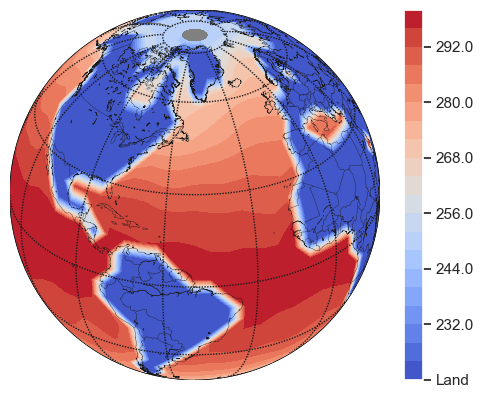

In [184]:
draw_maps(tas_df,'Temp 2m Below Sea Surface','tas','Temperature (K)','lats_tas.png')

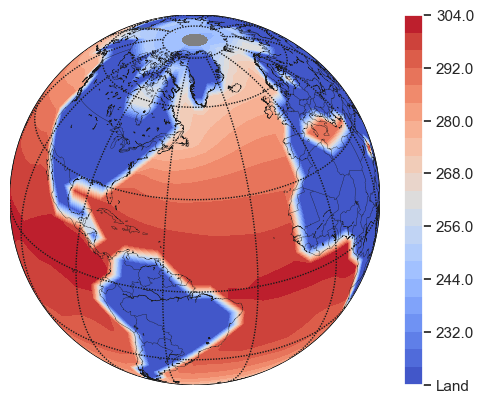

In [185]:
draw_maps(ts_df,'Sea Surface Temp','ts','Temperature (K)','lats_ts.png')

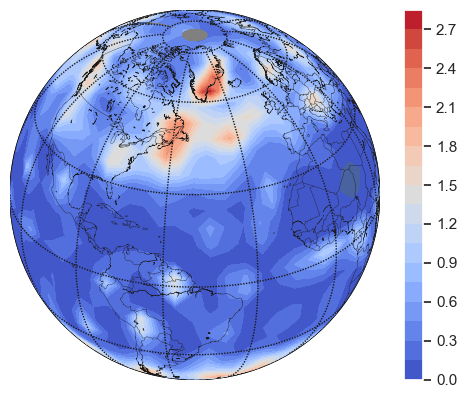

In [186]:
draw_maps(processed_lsp,'Large Scale Precipitation','prl','Precipitation in mm/day','lats_prl.png')

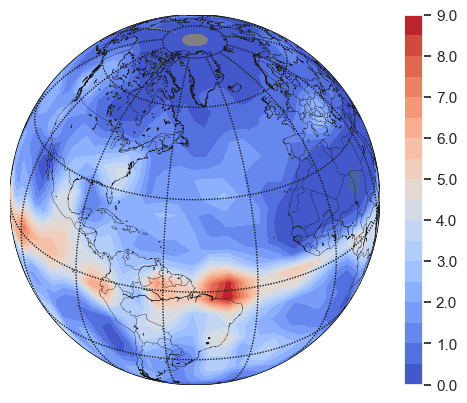

In [187]:
draw_maps(processed_cp,'Convective Precipitation','prc','Precipitation in mm/day','lats_prc.png')